Importamos las librerías que usaremos para este modelo

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report,roc_curve, auc
from sklearn.preprocessing import label_binarize

Cargamos la base de datos

In [47]:
dataNorm = pd.read_csv("../data/Hospitales_Normalizados.csv",index_col=0)

Definimos nuestras variables predictoras **X _(features)_** y la etiqueta a predecir **y _(target)_**

In [48]:
X = dataNorm.drop(columns="HOSPITALIZACION")
y = dataNorm["HOSPITALIZACION"]

Ahora que ya definimos las variables, vamos a separar nuestros datos en entrenamiento y testeo. Utilizaremos el 20% del dataset para evaluar.

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

Realizaremos una _`búsqueda exhaustiva`_ para encontrar los mejores hiperparámetros del modelo de clasificación. Utilizaremos la técnica de **_Grid Search Cross-Validation_**, que nos permitirá explorar diferentes combinaciones de hiperparámetros y evaluar su rendimiento mediante la validación cruzada. 

Nuestro objetivo es encontrar los valores óptimos para los hiperparámetros **`'n_neighbors','algorithm','leaf_size','weights' y 'p'.`**

In [50]:
clf = KNeighborsClassifier()

rango_hiperparametros = {"n_neighbors":[i for i in range(1,20)],
                       "algorithm":["auto", "kd_tree","ball_tree","brute"],
                       "leaf_size": [1,3,5,7,9,11],
                       "weights":["uniform", "distance"],
                       "p":[1,2]}

modelo = GridSearchCV(clf, param_grid = rango_hiperparametros,cv = 5, verbose = True)

modelo.fit(X, y)

print("Mejores hiperparámetros: "+ str(modelo.best_params_))
print("Mejor Score: "+str(modelo.best_score_)+'\n')

Fitting 5 folds for each of 1824 candidates, totalling 9120 fits
Mejores hiperparámetros: {'algorithm': 'brute', 'leaf_size': 1, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Mejor Score: 0.9748712998713



#### Creamos el modelo de K-Vecinos con los mejores hiperparametros,lo entrenamos y predecimos sobre el set de entrenamiento. 

In [51]:
from sklearn.neighbors import KNeighborsClassifier

#Instanciamos el modelo
clf = KNeighborsClassifier(algorithm="brute",leaf_size=1,n_neighbors=4,p=1,weights="distance")

#Entrenamos el modelo
clf.fit(X_train, y_train)

#Predecimos sobre nuestro set de entrenamieto
y_train_pred = clf.predict(X_train)

#Predecimos sobre nuestro set de testeo
y_test_pred = clf.predict(X_test)

#### **`Matriz de confusión`**
#### Veamos la matriz de nuestro modelo

In [52]:
#Para crear la matriz de confusión
from sklearn.metrics import confusion_matrix

matrix_train = confusion_matrix(y_train, y_train_pred)
matrix_test = confusion_matrix(y_test, y_test_pred)

#Para visualizar
from sklearn.metrics import ConfusionMatrixDisplay

cm_display_train = ConfusionMatrixDisplay(matrix_train)
cm_display_test = ConfusionMatrixDisplay(matrix_test)

#Para obtener el valor de precisión, recall, F1-score y soporte para cada clase en un problema de clasificación
from sklearn.metrics import classification_report

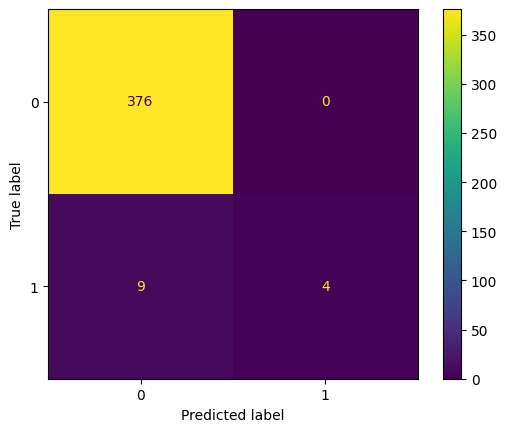

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.98      1.00      0.99       376
           1       1.00      0.31      0.47        13

    accuracy                           0.98       389
   macro avg       0.99      0.65      0.73       389
weighted avg       0.98      0.98      0.97       389



In [53]:
cm_display_train.plot()
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(y_train, y_train_pred)}''')

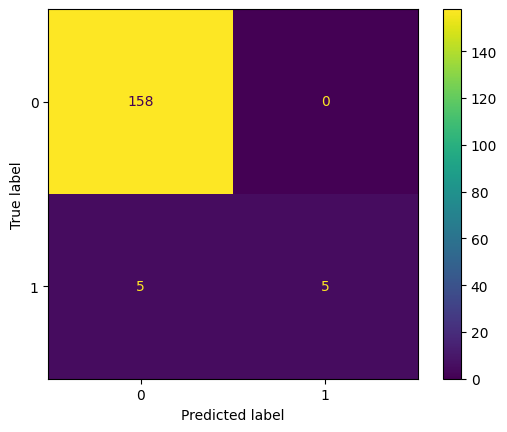

-----------------------------------------------------------------------
                    precision    recall  f1-score   support

           0       0.97      1.00      0.98       158
           1       1.00      0.50      0.67        10

    accuracy                           0.97       168
   macro avg       0.98      0.75      0.83       168
weighted avg       0.97      0.97      0.97       168



In [54]:
cm_display_test.plot()
plt.show()
print(f'''-----------------------------------------------------------------------
      {classification_report(y_test, y_test_pred)}''')

#### **`Curvas ROC `**

In [55]:
from sklearn.preprocessing import label_binarize

# Binarizamos las etiquetas del conjunto de prueba
y_test2 = label_binarize(y_test, classes=[0,1,2])

# Obtenemos el número de clases presentes en los datos
n_classes = y_test2.shape[1]

# Calculamos las probabilidades de predicción para cada clase en el conjunto de prueba
y_score = clf.predict_proba(X_test)


Calculamos las tasas de falsos positivos (FPR), las tasas de verdaderos positivos (TPR) y el AUC para cada clase en comparación con el resto de las clases

In [56]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes-1):
    fpr[i], tpr[i], _ = roc_curve(y_test2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

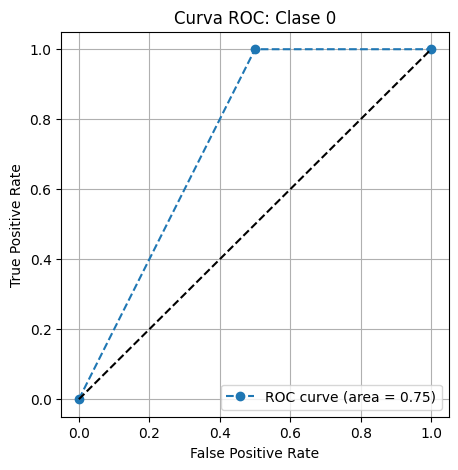

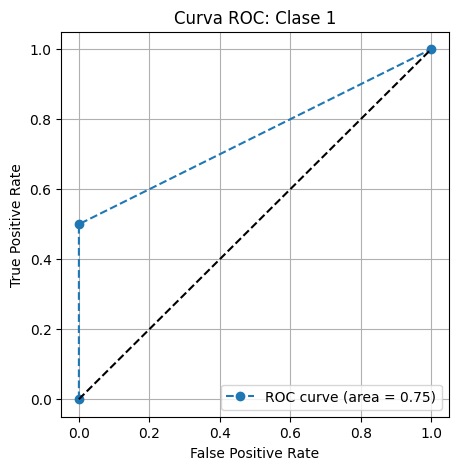

In [57]:
#Recorremos con un bucle cada una de las clases
for i in range(n_classes-1):
    plt.figure(figsize=(5,5))
    plt.plot(fpr[i], tpr[i],'o--', label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC: Clase ' + str(i))
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

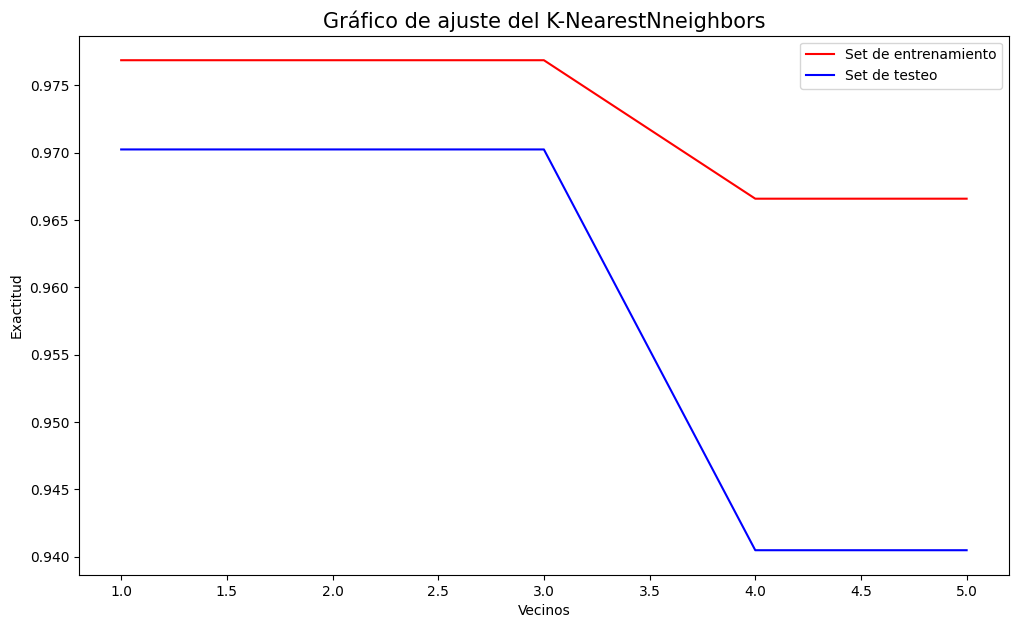

In [64]:
train_prec =  []
test_prec = []
max_KNN_list = list(range(1, 6))

for k in max_KNN_list:
    clf_3 = KNeighborsClassifier(n_neighbors=k)
    clf_3.fit(X_train, y_train)
    train_prec.append(clf_3.score(X_train, y_train))
    test_prec.append(clf_3.score(X_test, y_test))

plt.figure(figsize=(12,7))
plt.plot(max_KNN_list, train_prec, color='r', label='Set de entrenamiento')
plt.plot(max_KNN_list, test_prec, color='b', label='Set de testeo')
plt.title('Gráfico de ajuste del K-NearestNneighbors', fontsize = 15)
plt.legend()
plt.ylabel('Exactitud')
plt.xlabel('Vecinos')
plt.show()